In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2

# Util functions

In [2]:
def sort_by_name(arr, split_at):
    return sorted([f for f in arr if f.split(split_at)[0].isdigit()], key=lambda x: int(x.split(split_at)[0]))


import os
import numpy as np
import random

def load_data(dir_path, size=0.1):
    #dir_path = '/kaggle/input/deepglobe-road-extraction-dataset/train/'
    directory = os.listdir(dir_path)
    images = []
    masks = []

    for filename in directory:
        if filename.split('.')[1] == 'jpg':
            images.append(filename)
        elif filename.split('.')[1] == 'png':
            masks.append(filename)

    sorted_images = sort_by_name(images, '_')
    sorted_masks = sort_by_name(masks, '_')

    # Select 10% of the data
    sample_size = int(size * len(sorted_images))
    selected_indices = random.sample(range(len(sorted_images)), sample_size)
    
    selected_images = [sorted_images[i] for i in selected_indices]
    selected_masks = [sorted_masks[i] for i in selected_indices]

    return np.array(selected_images), np.array(selected_masks)





    return images, masks


In [3]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from scipy.ndimage import rotate

def add_noise(img_array, noise_factor=0.1):
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=img_array.shape)
    noisy_img = img_array + noise
    noisy_img = np.clip(noisy_img, 0.0, 1.0)  # Ensure pixel values stay within [0, 1]
    return noisy_img

def flip_left_right(img_array):
    return np.fliplr(img_array)

def flip_up_down(img_array):
    return np.flipud(img_array)

def crop(img_array, crop_size):
    height, width, _ = img_array.shape
    top = random.randint(0, height - crop_size[0])
    left = random.randint(0, width - crop_size[1])
    return img_array[top:top + crop_size[0], left:left + crop_size[1]]

def rotate_img(img_array, angle):
    return rotate(img_array, angle, reshape=False)

def mixup(img1, img2, label1, label2, alpha=0.2):
    """Apply MixUp augmentation."""
    beta = np.random.beta(alpha, alpha)
    img_mixed = beta * img1 + (1 - beta) * img2
    label_mixed = beta * label1 + (1 - beta) * label2
    return img_mixed, label_mixed

def cutmix(img1, img2, label1, label2, beta=1.0):
    """Apply CutMix augmentation."""
    height, width, _ = img1.shape
    lambda_cutmix = np.random.beta(beta, beta)
    crop_size = int(np.sqrt(1 - lambda_cutmix) * height)

    y1 = np.random.randint(0, height - crop_size)
    x1 = np.random.randint(0, width - crop_size)
    y2 = y1 + crop_size
    x2 = x1 + crop_size

    img1[y1:y2, x1:x2, :] = img2[y1:y2, x1:x2, :]
    label_mixed = lambda_cutmix * label1 + (1 - lambda_cutmix) * label2

    return img1, label_mixed

def random_augmentation(img_array, mask_array, crop_size=(100, 100)):
    """Apply a random augmentation technique."""
    augmentation = random.choice(['none', 'flip_lr', 'flip_ud', 'noise', 'crop', 'rotate', 'mixup', 'cutmix'])

    if augmentation == 'flip_lr':
        return flip_left_right(img_array), flip_left_right(mask_array)
    elif augmentation == 'flip_ud':
        return flip_up_down(img_array), flip_up_down(mask_array)
    elif augmentation == 'noise':
        return add_noise(img_array), mask_array
    elif augmentation == 'crop':
        return crop(img_array, crop_size), crop(mask_array, crop_size)
    elif augmentation == 'rotate':
        angle = random.uniform(-30, 30)  # Random rotation between -30 and 30 degrees
        return rotate_img(img_array, angle), rotate_img(mask_array, angle)
    elif augmentation == 'mixup':
        if len(images) > 1:  # Ensure there are at least 2 images for MixUp
            other_img, other_mask = random.choice(images), random.choice(masks)
            return mixup(img_array, other_img, mask_array, other_mask), mask_array
        else:
            return img_array, mask_array
    elif augmentation == 'cutmix':
        if len(images) > 1:  # Ensure there are at least 2 images for CutMix
            other_img, other_mask = random.choice(images), random.choice(masks)
            return cutmix(img_array, other_img, mask_array, other_mask), mask_array
        else:
            return img_array, mask_array
    else:
        return img_array, mask_array

def preprocess_data(root_path, sorted_images, sorted_masks, input_size, augmented=False):
    images = []
    masks = []

    for img_file, mask_file in zip(sorted_images, sorted_masks):
        img = load_img(root_path + img_file, target_size=input_size, color_mode='rgb')
        mask = load_img(root_path + mask_file, target_size=input_size, color_mode='grayscale')

        # Convert image and mask to arrays
        img_array = img_to_array(img)
        img_array = img_array / 255.0

        mask_array = img_to_array(mask, dtype=np.bool_)

        # Append images and masks to the lists
        images.append(img_array)
        masks.append(mask_array)

        if augmented:
            aug_img, aug_mask = random_augmentation(img_array, mask_array)
            images.append(aug_img)
            masks.append(aug_mask)

    # Convert lists to numpy arrays
    images = np.array(images)
    masks = np.array(masks)
    
    return images, masks


In [4]:
def display_data(dir_path, image_paths, mask_paths):

    fig, axes = plt.subplots(5, 2, figsize=(10, 20))

    # Iterate over the image and mask pairs and display them in subplots
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        # Load the image and mask using your preferred method
        image = plt.imread(dir_path + image_path)
        mask = plt.imread(dir_path + mask_path)

        # Plot the image and mask in the corresponding subplot
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask)
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    return

# Model Architecture

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate, Conv2DTranspose

def unet(input_shape, output_layer):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv2 = Dropout(0.1)(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv3 = Dropout(0.2)(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4 = Dropout(0.2)(conv4)

    # Bottom
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Dropout(0.3)(conv5)

    # Decoder
    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = Concatenate()([conv4, up6])
    conv6 = Dropout(0.2)(merge6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = Concatenate()([conv3, up7])
    conv7 = Dropout(0.2)(merge7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)

    up8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = Concatenate()([conv2, up8])
    conv8 = Dropout(0.1)(merge8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    conv8 = tf.keras.layers.BatchNormalization()(conv8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    conv8 = tf.keras.layers.BatchNormalization()(conv8)

    up9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = Concatenate()([conv1, up9])
    conv9 = Dropout(0.1)(merge9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    conv9 = tf.keras.layers.BatchNormalization()(conv9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    conv9 = tf.keras.layers.BatchNormalization()(conv9)

    # Output
    output = Conv2D(output_layer, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)
    return model

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
print('GPU is available' if len(physical_devices) > 0 else 'Not available')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPU is available


In [7]:
# initialize input size and shape
INPUT_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3) # color images, 3 channels

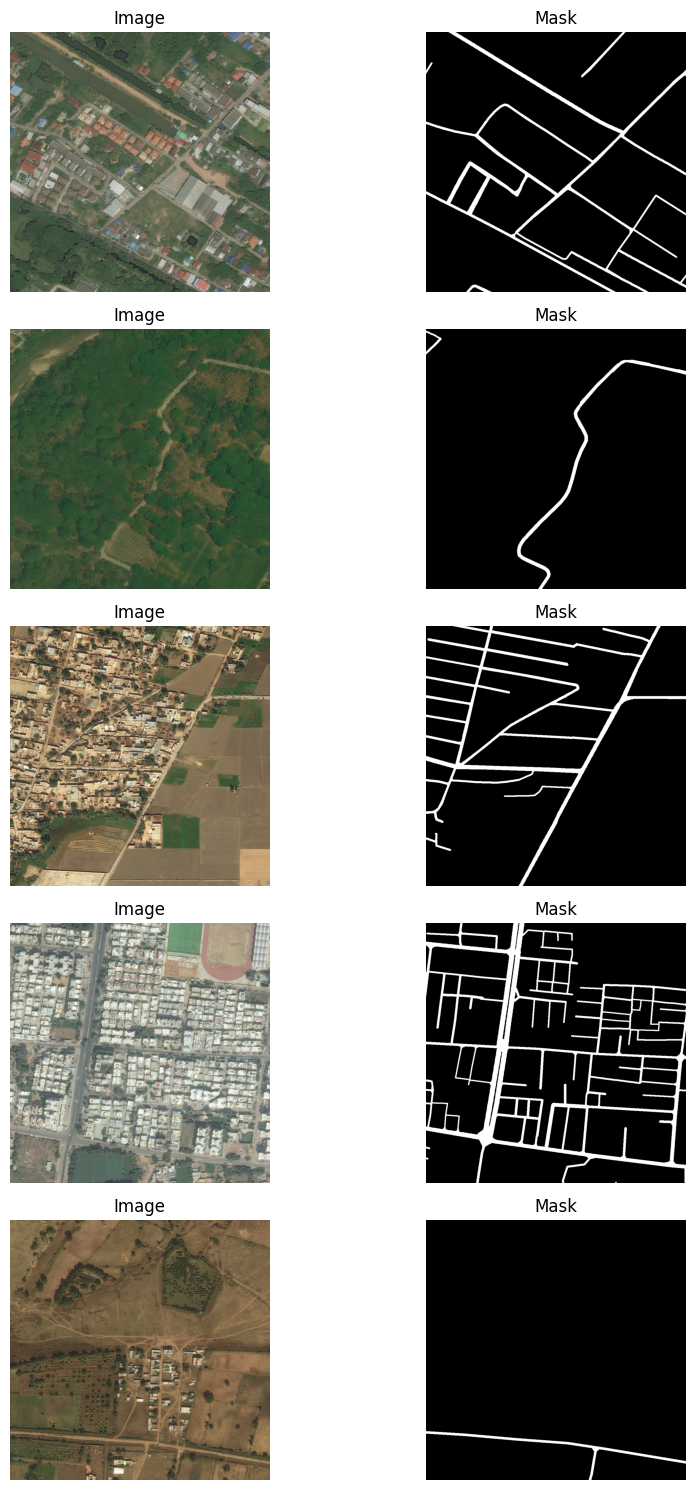

In [8]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import random

def display_data(dir_path, image_paths, mask_paths):

    fig, axes = plt.subplots(5, 2, figsize=(10, 15))

    # Iterate over the image and mask pairs and display them in subplots
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        # Load the image and mask using your preferred method
        image = plt.imread(dir_path + image_path)
        mask = plt.imread(dir_path + mask_path)

        # Plot the image and mask in the corresponding subplot
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask)
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.savefig('samples.png', bbox_inches='tight')  # Save as PNG image

    # Show the plot
    plt.show()
    return

# load data
dir_path = '/kaggle/input/deepglobe-road-extraction-dataset/train/'
image_filenames, mask_filenames = load_data(dir_path)
# display the first 5 pairs of image and mask
random_indices = random.sample(range(0, len(image_filenames)), 5)
display_data(dir_path, image_filenames[random_indices], mask_filenames[random_indices])

In [9]:
# preprocess data
with tf.device("/device:GPU:0"):
    # no augmentation due to limited computational resources
    # already have a large amount of data, roughly 12,000 images and masks
    images, masks = preprocess_data(dir_path, image_filenames, mask_filenames, input_size=INPUT_SIZE, augmented=False) 

In [10]:
# get shape
print('Shape of image data: ' + str(images.shape))
print('Shape of mask data: ' + str(masks.shape))

Shape of image data: (622, 256, 256, 3)
Shape of mask data: (622, 256, 256, 1)


In [11]:
# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
train_images, test_images, train_masks, test_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

In [12]:
# save check point
checkpoint = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/models/save_best.keras', verbose=1, save_best_only=True)

In [13]:
# Initialize the model
model = unet(INPUT_SHAPE, output_layer=1)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 1,946,993 (7.43 MB)

 Trainable params: 1,944,049 (7.42 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [14]:
# complie the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
epochs = 50
with tf.device("/GPU:0"):
    history = model.fit(train_images, train_masks, batch_size=16, epochs=epochs, validation_data=(val_images, val_masks), callbacks=[checkpoint])


Epoch 1/50


I0000 00:00:1726404343.220597    4655 service.cc:145] XLA service 0x7b7008002a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726404343.220689    4655 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5048 - loss: 0.8907  

I0000 00:00:1726404368.703678    4655 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5517 - loss: 0.7898  
Epoch 1: val_loss improved from inf to 20.84775, saving model to /kaggle/working/models/save_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5539 - loss: 0.7872 - val_accuracy: 0.5691 - val_loss: 20.8478
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7980 - loss: 0.6122
Epoch 2: val_loss improved from 20.84775 to 1.00035, saving model to /kaggle/working/models/save_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.7992 - loss: 0.6115 - val_accuracy: 0.6715 - val_loss: 1.0003
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8888 - loss: 0.5432
Epoch 3: val_loss improved from 1.00035 to 0.42205, saving model to /kaggle/working/models/save_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8893 - loss: 0.5426 - val_accuracy: 0.9249 - val_loss: 0.4220
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9299 - loss: 0.4763
Epoc

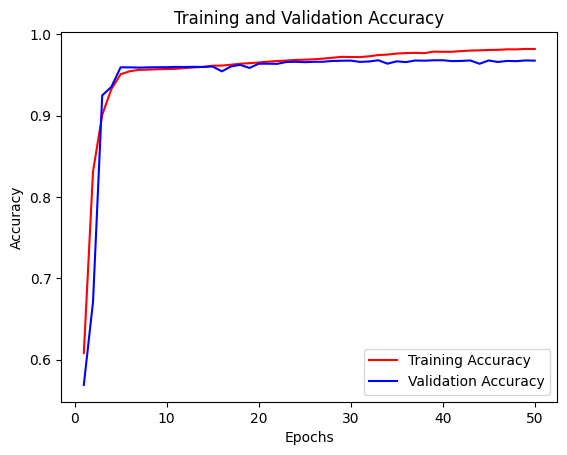

In [16]:
# Accessing training and testing accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, epochs + 1)

# Plotting
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
eval = model.evaluate(test_images, test_masks)
print('Test accuracy: ' + "{:.2f}".format(eval[1]))

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 596ms/step - accuracy: 0.9700 - loss: 0.1016
Test accuracy: 0.97


## Original Test accuracy: 0.98

# 20 epochs 
### 0.97 with 10% of data
### 0.96 with 10% of data and noise added 
### 0.96 with 10% of data and noise, crop, flip
### 0.97 with 20% of data and noise, crop, flip
### 0.96 with 20% of data and noise, crop, flip, cutmix, mixup
# 50 epochs 
### 0.96 with 10% of data
### 0.97 with 20% of data 
### 0.97 with 10% of data and noise, crop, flip, cutmix, mixup



In [18]:
from tensorflow.keras.models import load_model
# load the saved model due to prior interuption
model = load_model('/kaggle/working/models/save_best.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


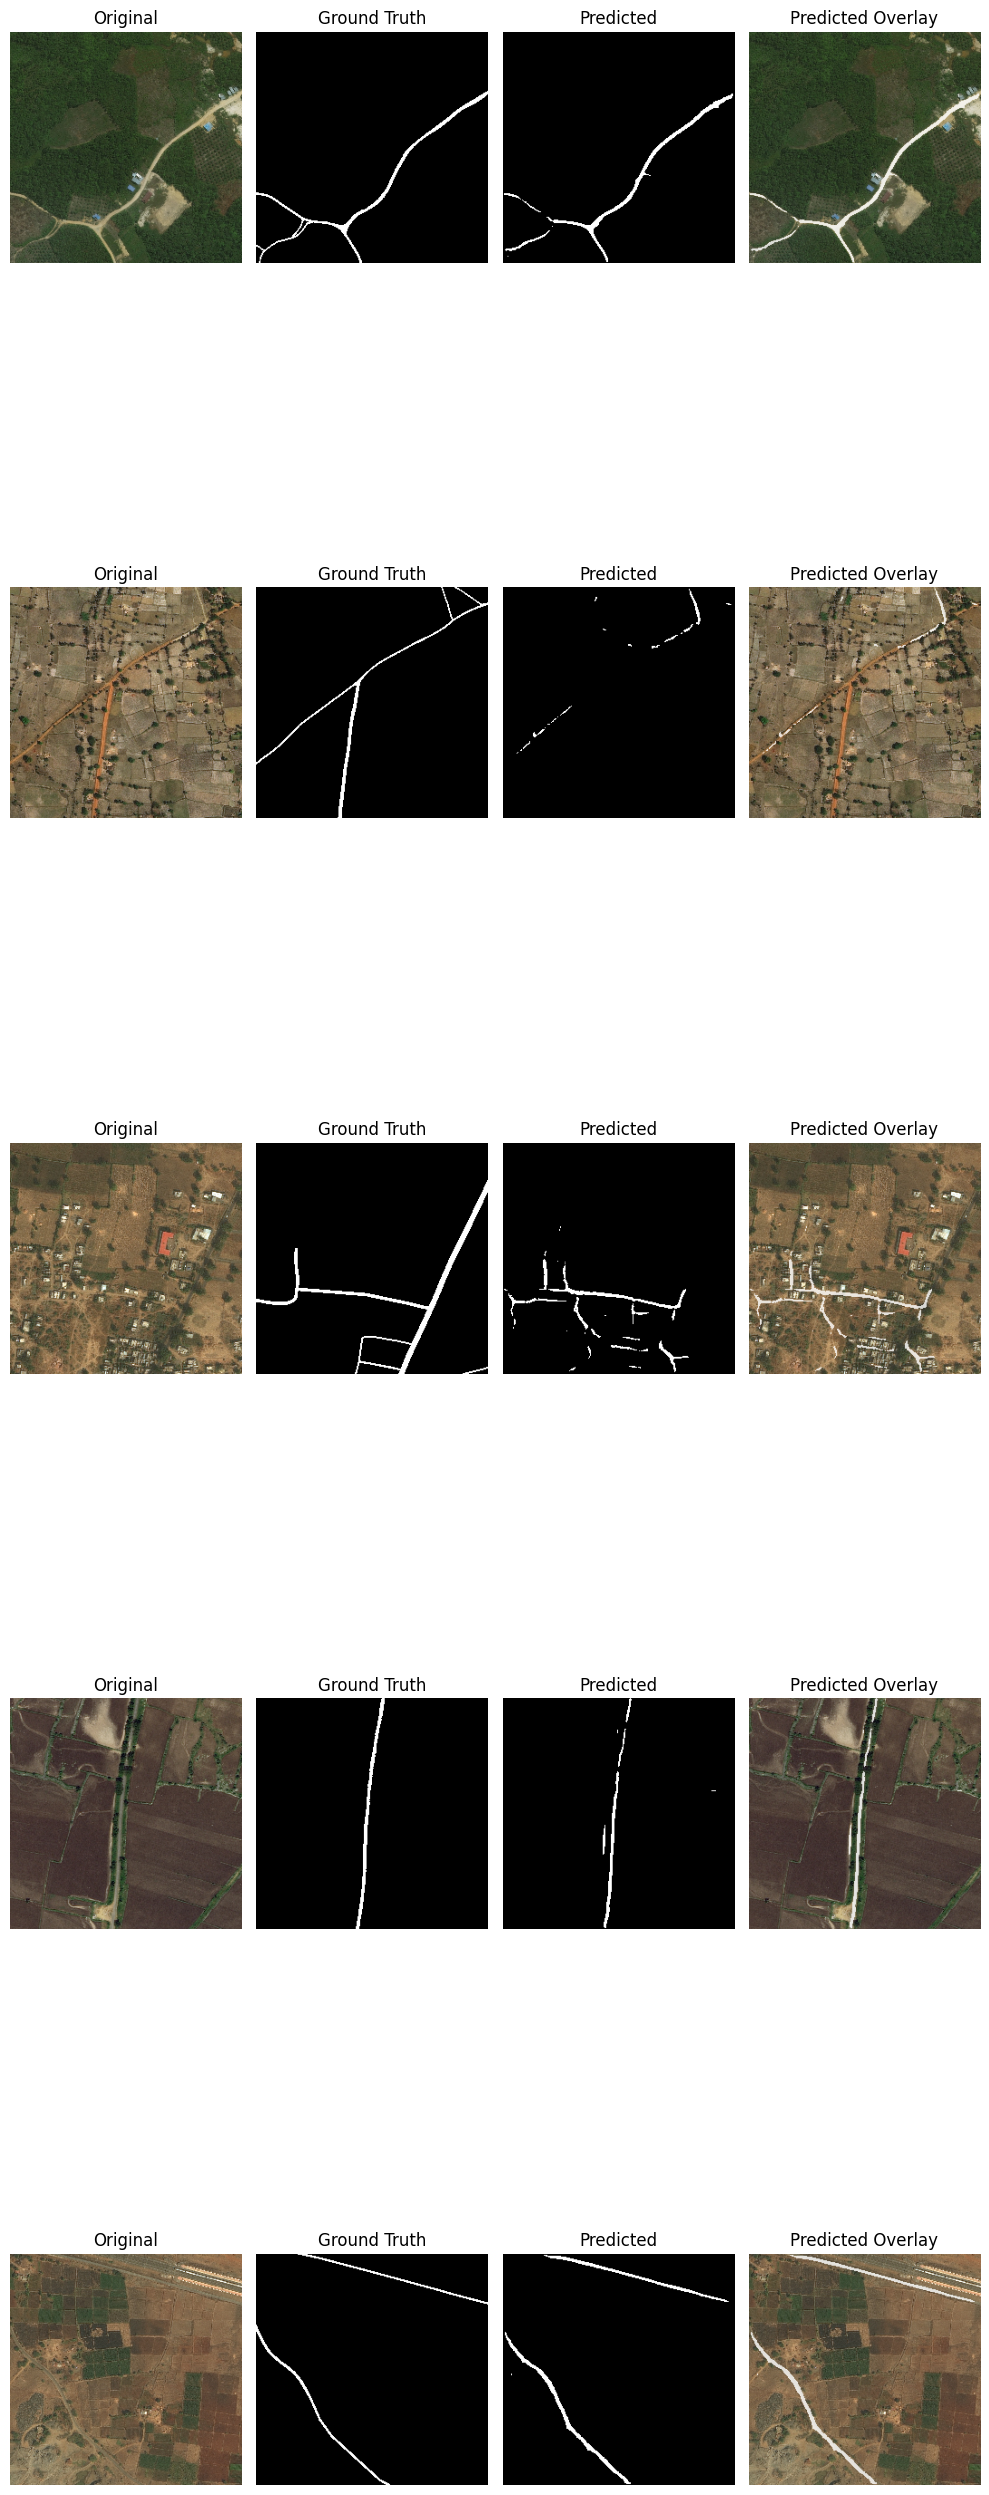

In [19]:
# display 10 random predictions
random_indices = random.sample(range(0, len(test_images)), 5)
test_sample = test_images[random_indices]

predictions = model.predict(test_sample)
predictions = (predictions > 0.5).astype(np.uint8)

fig, axes = plt.subplots(5, 4, figsize=(10, 3*10))

# Iterate over the image and mask pairs and display them in subplots
for i in range(len(test_sample)):

    image = (test_sample[i] * 255).astype(np.uint8)
    mask = predictions[i]
    ground_truth = test_masks[random_indices][i] * np.array([255, 255, 255]) # convert the forground into yellow color to achieve the desired aesthetic

    overlay = image.copy()

    mask = np.repeat(mask, 3, axis=2) # matching the size of the channel of the mask and the image to perform an overlay
    inverted_mask = 1 - mask

    yellow_mask = np.array([255, 255, 255]) * mask

    # Apply the mask on the image
    result = image * inverted_mask + yellow_mask
    alpha = 0.2
    predicted_overlay = cv2.addWeighted(overlay, alpha, result.astype(overlay.dtype), 1 - alpha, 0)

    # Plot the image and mask in the corresponding subplot
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(ground_truth)
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(yellow_mask)
    axes[i, 2].set_title('Predicted')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(predicted_overlay)
    axes[i, 3].set_title('Predicted Overlay')
    axes[i, 3].axis('off')
    
# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('result.png', bbox_inches='tight')  # Save as PNG image

# Show the plot
plt.show()
# save the output